In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


In [13]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

print(f"Train: {train.shape}, Test: {test.shape}")
print(f"Features: {features.shape}, Stores: {stores.shape}")

# Convert dates
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
features['Date'] = pd.to_datetime(features['Date'])

print(f"Date ranges - Train: {train['Date'].min()} to {train['Date'].max()}")
print(f"Stores: {train['Store'].nunique()}, Departments: {train['Dept'].nunique()}")

Train: (421570, 5), Test: (115064, 4)
Features: (8190, 12), Stores: (45, 3)
Date ranges - Train: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Stores: 45, Departments: 81


In [14]:
# Merge datasets
train_merged = train.merge(features, on=['Store', 'Date'], how='left')
train_merged = train_merged.merge(stores, on='Store', how='left')

test_merged = test.merge(features, on=['Store', 'Date'], how='left')
test_merged = test_merged.merge(stores, on='Store', how='left')

print(f"Merged train: {train_merged.shape}")
print(f"Merged test: {test_merged.shape}")
print(f"Columns: {list(train_merged.columns)}")

Merged train: (421570, 17)
Merged test: (115064, 16)
Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size']


In [15]:
# Sales statistics
print("Weekly Sales Statistics:")
print(train_merged['Weekly_Sales'].describe())

print(f"\nMissing values:")
missing = train_merged.isnull().sum()
print(missing[missing > 0])

print(f"\nStore types:")
print(train_merged['Type'].value_counts())

Weekly Sales Statistics:
count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

Missing values:
MarkDown1    270889
MarkDown2    310322
MarkDown3    284479
MarkDown4    286603
MarkDown5    270138
dtype: int64

Store types:
Type
A    215478
B    163495
C     42597
Name: count, dtype: int64


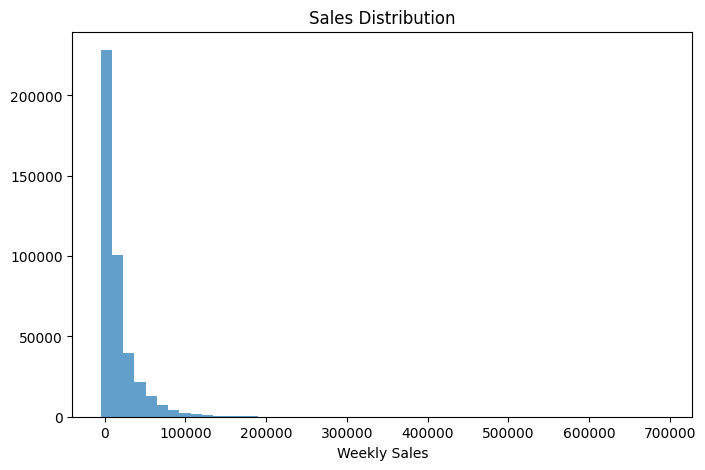

<Figure size 500x500 with 0 Axes>

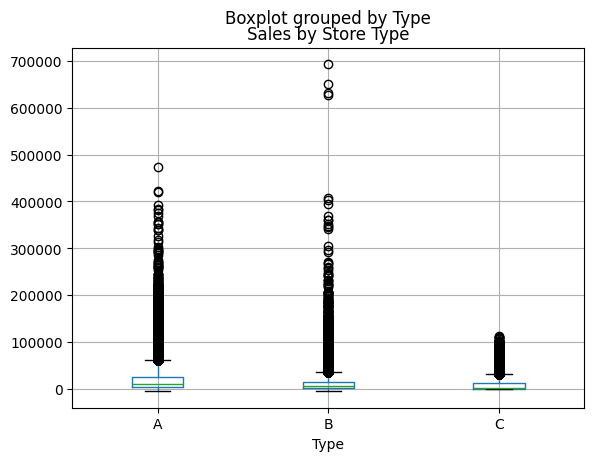

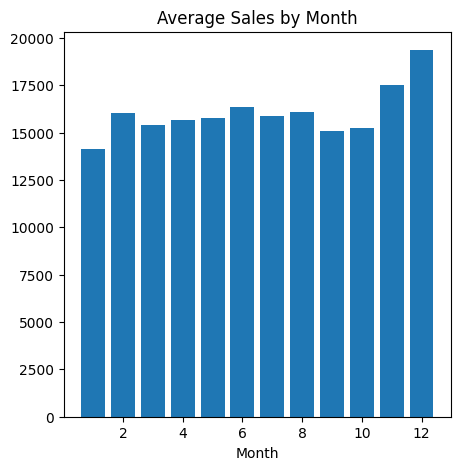

In [16]:
# Sales distribution
plt.figure(figsize=(8 , 5))
plt.hist(train_merged['Weekly_Sales'], bins=50, alpha=0.7)
plt.title('Sales Distribution')
plt.xlabel('Weekly Sales')
plt.show()

# Sales by store type
plt.figure(figsize=(5 , 5))
train_merged.boxplot(column='Weekly_Sales', by='Type')
plt.title('Sales by Store Type')
plt.show()

# Monthly trends
plt.figure(figsize=(5 , 5))
monthly_sales = train_merged.groupby(train_merged['Date'].dt.month)['Weekly_Sales'].mean()
plt.bar(monthly_sales.index, monthly_sales.values)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.show()

In [17]:
# Handle missing values
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    train_merged[col] = train_merged[col].fillna(0)
    test_merged[col] = test_merged[col].fillna(0)

train_merged = train_merged.fillna(method='ffill').fillna(0)
test_merged = test_merged.fillna(method='ffill').fillna(0)


In [18]:
# Create features
def create_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
    return df

train_merged = create_features(train_merged)
test_merged = create_features(test_merged)

# Encode store type
le = LabelEncoder()
train_merged['Type_encoded'] = le.fit_transform(train_merged['Type'])
test_merged['Type_encoded'] = le.transform(test_merged['Type'])


In [19]:
# Create simple lag features (skip rolling averages to avoid index issues)
train_merged = train_merged.sort_values(['Store', 'Dept', 'Date'])

train_merged['Sales_Lag1'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
train_merged['Sales_Lag2'] = train_merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)


In [20]:
# Select features
feature_cols = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
               'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
               'Type_encoded', 'Size', 'Year', 'Month', 'Week', 'DayOfWeek', 
               'Quarter', 'IsWeekend', 'IsHoliday_x']

# Time-aware split
split_date = train_merged['Date'].quantile(0.8)
train_mask = train_merged['Date'] <= split_date
val_mask = train_merged['Date'] > split_date

X_train = train_merged[train_mask][feature_cols]
X_val = train_merged[val_mask][feature_cols]
y_train = train_merged[train_mask]['Weekly_Sales']
y_val = train_merged[val_mask]['Weekly_Sales']

X_train['IsHoliday_x'] = X_train['IsHoliday_x'].astype(int)
X_val['IsHoliday_x'] = X_val['IsHoliday_x'].astype(int)

print(f"Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}")

Train: 338738, Validation: 82832


In [21]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_val)

lr_mse = mean_squared_error(y_val, lr_pred)
lr_mae = mean_absolute_error(y_val, lr_pred)
lr_r2 = r2_score(y_val, lr_pred)

print("Linear Regression:")
print(f"MSE: {lr_mse:,.0f}, MAE: {lr_mae:,.0f}, R²: {lr_r2:.4f}")

Linear Regression:
MSE: 438,661,764, MAE: 14,667, R²: 0.0910


In [22]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

rf_mse = mean_squared_error(y_val, rf_pred)
rf_mae = mean_absolute_error(y_val, rf_pred)
rf_r2 = r2_score(y_val, rf_pred)

print("Random Forest:")
print(f"MSE: {rf_mse:,.0f}, MAE: {rf_mae:,.0f}, R²: {rf_r2:.4f}")

Random Forest:
MSE: 14,127,748, MAE: 1,807, R²: 0.9707


In [23]:
# XGBoost (BONUS)
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)

xgb_mse = mean_squared_error(y_val, xgb_pred)
xgb_mae = mean_absolute_error(y_val, xgb_pred)
xgb_r2 = r2_score(y_val, xgb_pred)

print("XGBoost:")
print(f"MSE: {xgb_mse:,.0f}, MAE: {xgb_mae:,.0f}, R²: {xgb_r2:.4f}")

XGBoost:
MSE: 28,842,783, MAE: 3,292, R²: 0.9402


In [24]:
# Compare models
results = [
    {'Model': 'Linear Regression', 'MSE': lr_mse, 'MAE': lr_mae, 'R2': lr_r2},
    {'Model': 'Random Forest', 'MSE': rf_mse, 'MAE': rf_mae, 'R2': rf_r2},
    {'Model': 'XGBoost', 'MSE': xgb_mse, 'MAE': xgb_mae, 'R2': xgb_r2}
]

comparison_df = pd.DataFrame(results)
print("Model Comparison:")
print(comparison_df.round(4))

best_model = comparison_df.loc[comparison_df['R2'].idxmax(), 'Model']
print(f"\nBest model: {best_model}")

Model Comparison:
               Model           MSE         MAE      R2
0  Linear Regression  4.386618e+08  14666.8375  0.0910
1      Random Forest  1.412775e+07   1807.3697  0.9707
2            XGBoost  2.884278e+07   3291.8277  0.9402

Best model: Random Forest


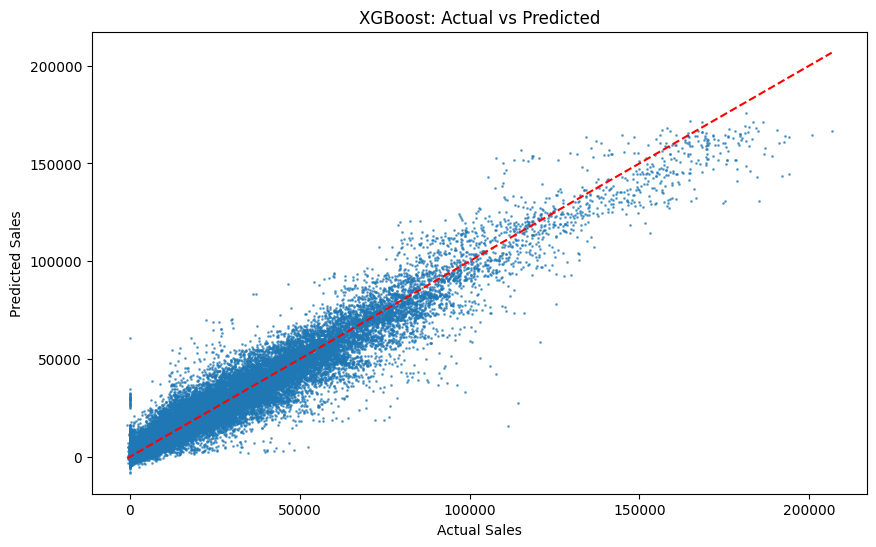

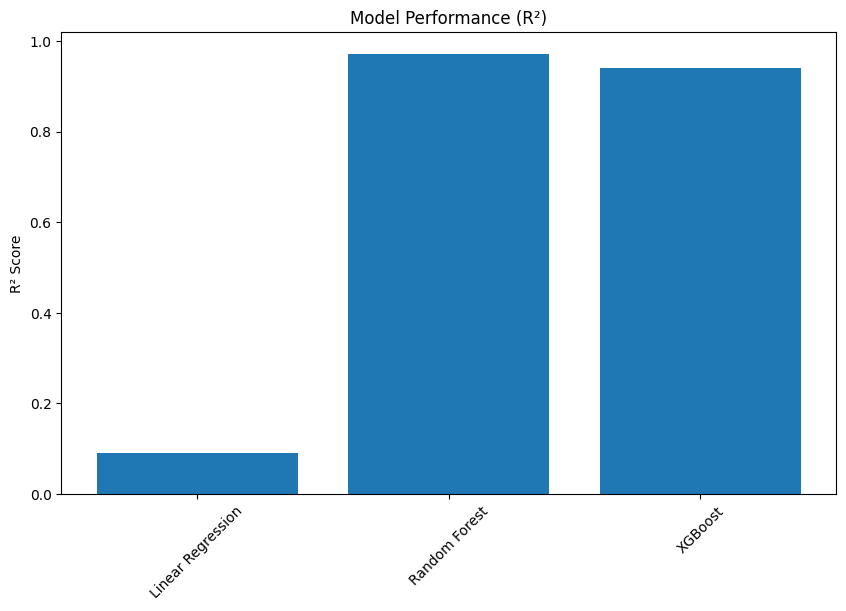

In [25]:
# Scatter plot - Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_val, xgb_pred, alpha=0.6, s=1)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('XGBoost: Actual vs Predicted')
plt.show()

# Model comparison
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Model'], comparison_df['R2'])
plt.title('Model Performance (R²)')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.show()

Top 10 Features:
         feature  importance
1           Dept    0.250480
12          Size    0.241896
11  Type_encoded    0.097401
0          Store    0.079114
8      MarkDown3    0.060696
15          Week    0.056734
19   IsHoliday_x    0.046549
14         Month    0.044127
4            CPI    0.041416
13          Year    0.025336


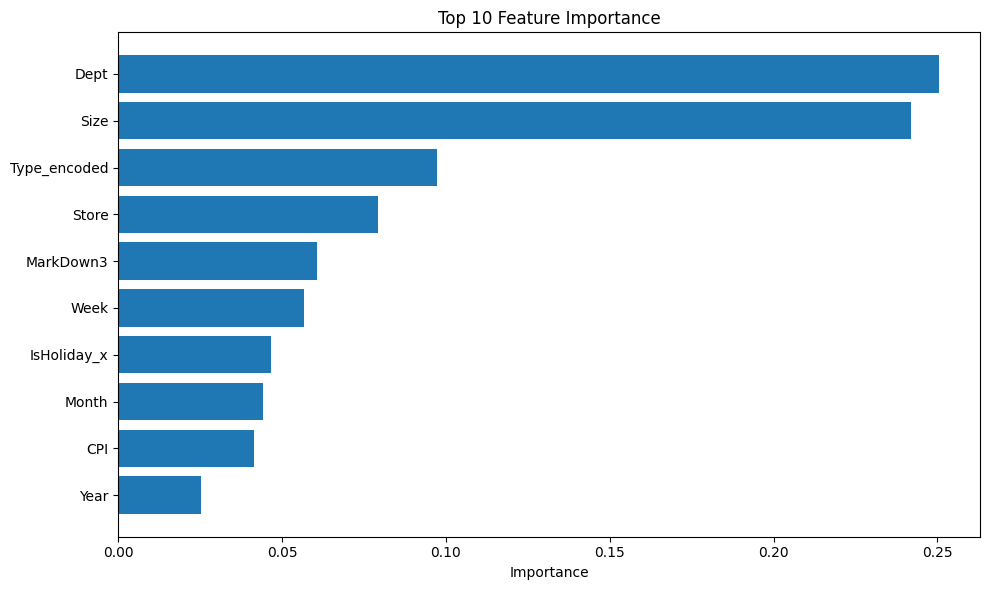

In [26]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Features:")
print(importance_df.head(10))

# Plot
plt.figure(figsize=(10, 6))
top_10 = importance_df.head(10)
plt.barh(top_10['feature'], top_10['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()